# Задание 1 (рандомный классификатор)

Самостоятельное задание: постройте бейзлайн в виде рандомного предсказания классов. Выбор класса должен делаться случайным образом, но вероятность класса $1$ возьмите такую же, как в исходном датасете.

In [1]:
# загрузка библиотек
import logging
import os
import shutil
import numpy as np
import pandas as pd
import random
import sklearn.metrics as metrics
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
import scipy

In [2]:
# загрузка данных

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

logging.getLogger().setLevel(logging.INFO)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')


sharing_url = "https://drive.google.com/file/d/15_YokQyNcfP8IlsOVc7uxgxOYDIKwB0q/view?usp=sharing"
download_url = "https://drive.google.com/uc?id=" + sharing_url.split("/")[-2]

df_source = pd.read_csv(
    download_url,
    dtype={
        'call_diff': np.float32,
        'call_diff': np.float32,
        'traffic_diff': np.float32,
        'customes_class': np.uint16
    }
    )

# разбиение классов на 0 и 1
df_source[(df_source.customes_class==2) & (df_source.call_diff>1.1)] = 0
df_source[(df_source.customes_class==2) & (df_source.call_diff<=1.1)] = 1

X = df_source[['call_diff','sms_diff','traffic_diff']].values
y = df_source.customes_class.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=RANDOM_SEED)

INFO:__main__:Инициализировали логгер


In [3]:
df_source.head()

,call_diff,sms_diff,traffic_diff,customes_class
0,-0.666421,0.444911,-0.273538,0
1,1.000000,1.000000,1.000000,1
2,-0.841503,0.846665,0.727606,0
3,1.389749,0.390911,1.789246,1
4,1.000000,1.000000,1.000000,1


In [4]:
# для красоты
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [5]:
np.random.seed(RANDOM_SEED)
prob_1 = (df_source['customes_class'] == 1).sum()/len(df_source['customes_class'])
prob_0 = (df_source['customes_class'] == 0).sum()/len(df_source['customes_class'])

df_source['predictions'] = np.random.choice([1, 0],
                                            size=len(df_source['customes_class']),
                                            p=[prob_1, prob_0])


# оценим качество наших случайных предсказаний
print(color.BOLD, 'RANDOM CLASSIFIER', color.END)
print(metrics.classification_report(df_source['customes_class'],
                                    df_source['predictions']))
print('The ROC-AUC score is', metrics.roc_auc_score(df_source['customes_class'],
                                               df_source['predictions']))

 RANDOM CLASSIFIER 
              precision    recall  f1-score   support

           0       0.50      0.47      0.48        34
           1       0.74      0.76      0.75        66

    accuracy                           0.66       100
   macro avg       0.62      0.61      0.62       100
weighted avg       0.66      0.66      0.66       100

The ROC-AUC score is 0.6140819964349375


# Задание 2 (ROC-AUC)

Самостоятельное задание: посчитать используя библиотеку sklearn и визуализировать ROC-AUC для двух логистических регрессий выше.

In [6]:
# логистическая регрессия руками

def sigmoid(z):
  return 1 / ( 1. + np.exp(-z))

x = np.array([1, 2, 3, 5])
sigmoid(x)

def gradient(X, y, w, alpha=0) -> np.array:
    """Вычисляем градиент в точке"""
    # количество обучающих примеров в выборке
    n = X.shape[0]
    # считаем прогноз
    y_hat = sigmoid(X.dot(w.T))
    # вычисляем ошибку прогноза
    error = (y - y_hat).reshape(1, -1)
    # дальше pointwise перемножение - умножаем каждую из координат на ошибку
    grad = (-1.) * error.dot(X) / n
    return grad, error

def eval_w_next(X, y, eta, w_current):
    """Делаем шаг градиентного спуска"""
    # вычисляем градиент
    grad, error = gradient(X, y, w_current)
    # делаем шаг градиентного спуска
    w_next = w_current - eta*grad
    # проверяем условие сходимости
    weight_evolution = distance.euclidean(w_current[0], w_next[0])
    return (w_next, weight_evolution, grad)

def gradient_descent(X: np.array, y: np.array, eta=0.01, epsilon=0.001) -> np.array:
    m = X.shape[1] # количество фичей
    # инициализируем рандомом веса
    w = np.random.random(m).reshape(1, -1)
    w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
    step = 0
    # повторяем до сходимости вектора весов
    while weight_evolution > epsilon:
        w = w_next
        w_next, weight_evolution, grad = eval_w_next(X, y, eta, w)
        step += 1
        if step % 100 == 0:
            print("step %s |w-w_next|=%.5f, grad=%s" % (step, weight_evolution, grad))
    return w

# обучающие данные
X_train_extended = np.hstack([
    np.ones(X_train.shape[0]).reshape(-1,1),
    X_train
])
w = gradient_descent(
    X_train_extended,
    y_train.reshape(-1, 1),
    eta=0.008
)

# тестовые данные
X_test_extended = np.hstack([
    np.ones(X_test.shape[0]).reshape(-1,1),
    X_test
])


def predict(X, w):
  y_probas = sigmoid(X.dot(w.T))
  y_hat = np.zeros_like(y_probas)
  y_hat[np.where(y_probas >= 0.5)] = 1
  y_hat[np.where(y_probas < 0.5)] = 0
  y_hat = y_hat.flatten().astype(np.uint16)

  return y_hat

predicted_classes = predict(X_test_extended, w)
accuracy = (predicted_classes == y_test).sum() / len(y_test)
print('Предсказания построены, accuracy = %.2f' % accuracy)


step 100 |w-w_next|=0.00227, grad=[[ 0.055051   -0.25045085  0.06597664  0.10081882]]
step 200 |w-w_next|=0.00183, grad=[[ 0.03224997 -0.21170413  0.03675719  0.07143145]]
step 300 |w-w_next|=0.00154, grad=[[ 0.01944017 -0.18337704  0.01982304  0.05384442]]
step 400 |w-w_next|=0.00135, grad=[[ 0.01219204 -0.16185175  0.00986096  0.04317997]]
step 500 |w-w_next|=0.00120, grad=[[ 0.00800676 -0.14493692  0.00382613  0.03644717]]
step 600 |w-w_next|=0.00108, grad=[[ 5.53873612e-03 -1.31290345e-01  5.56476168e-05  3.19785566e-02]]
Предсказания построены, accuracy = 0.91


In [7]:
# ROC-AUC для ручной модели

y_probas_mlr = sigmoid(X_test_extended.dot(w.T)).flatten()
fpr_mlr, tpr_mlr, thresholds = metrics.roc_curve(y_test, y_probas_mlr)
roc_auc_score_mlr = metrics.roc_auc_score(y_test, y_probas_mlr)
print('AUC: %.2f' % roc_auc_score_mlr)

AUC: 0.98


In [8]:
# функция для дальнейших визуализаций ROC-AUC
def roc_auc_plot(title: str, fpr, tpr, label: str, roc_auc_score):
    plt.title(title)
    plt.plot(fpr, tpr, label=label % roc_auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.1, 1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

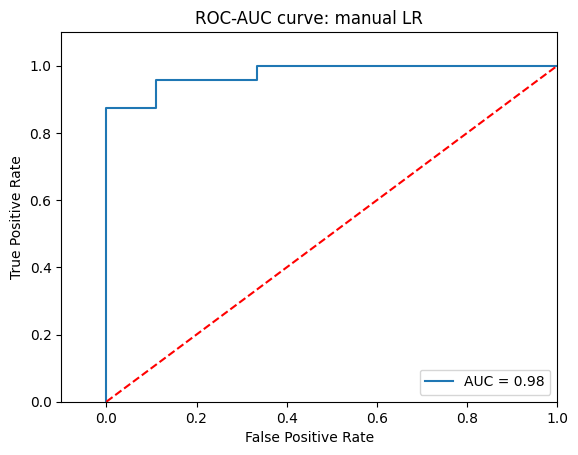

In [9]:
# визуализация
roc_auc_plot('ROC-AUC curve: manual LR', fpr_mlr, tpr_mlr,
             'AUC = %0.2f', roc_auc_score_mlr)

In [10]:
# реализация из коробки
log_reg = LogisticRegression().fit(X_train, y_train)

predicted_classes_lr = log_reg.predict(X_test)
accuracy = (predicted_classes_lr == y_test).sum() / len(y_test)
logger.info('Предсказания построены, accuracy = %.2f', accuracy)

INFO:__main__:Предсказания построены, accuracy = 0.94


In [11]:
# ROC-AUC для модели из коробки
y_probas_sk = log_reg.predict_proba(X_test)[:, 1]
fpr_sk, tpr_sk, thresholds_sk = metrics.roc_curve(y_test, y_probas_sk)
roc_auc_score_sk = metrics.roc_auc_score(y_test, y_probas_sk)
print('AUC: %.2f' % roc_auc_score_sk)

AUC: 0.99


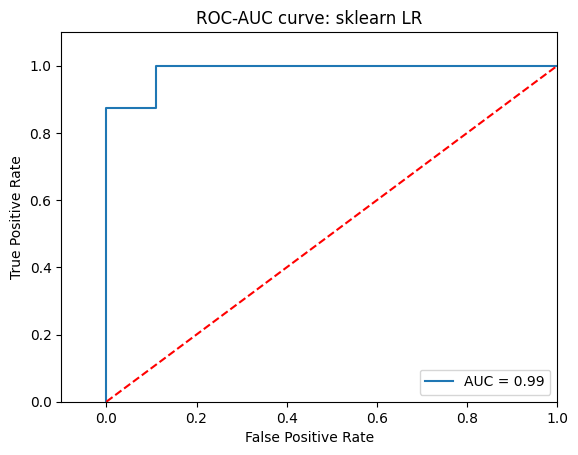

In [12]:
# визуализация
roc_auc_plot('ROC-AUC curve: sklearn LR', fpr_sk, tpr_sk,
             'AUC = %0.2f', roc_auc_score_sk)

Из интереса посмотрим на другие метрики обеих моделей.

In [13]:
print(color.BOLD + 'MANUAL LR' + color.END)
print(metrics.classification_report(y_test, predicted_classes))
print('_____________________________________________________')
print(color.BOLD + 'SKLEARN LR' + color.END)
print(metrics.classification_report(y_test, predicted_classes_lr))


MANUAL LR
              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.92      0.96      0.94        24

    accuracy                           0.91        33
   macro avg       0.90      0.87      0.88        33
weighted avg       0.91      0.91      0.91        33

_____________________________________________________
SKLEARN LR
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.96      0.96      0.96        24

    accuracy                           0.94        33
   macro avg       0.92      0.92      0.92        33
weighted avg       0.94      0.94      0.94        33



# Задание 3 (ручное ROC-AUC)
Самостоятельно реализовать функцию roc_auc_score и сравнить ее с результатами выше.

In [14]:
def manual_roc_auc(fpr, tpr):

    # т. к. мы считаем определенный интеграл, добавим точку в начало
    tpr = np.array(tpr+[0])
    fpr = np.array(fpr+[0])

    # метод трапеций; btw, смешной пост про его переоткрытие в 1994:
    # https://academia.stackexchange.com/questions/9602/rediscovery-of-calculus-in-1994-what-should-have-happened-to-that-paper
    roc_auc_score = 0
    for i in range(1, len(fpr)):
        roc_auc_score += (fpr[i] - fpr[i - 1]) * (tpr[i] + tpr[i - 1]) / 2

    return roc_auc_score

In [17]:
# сравниваем раз
mal_ra_mlr = manual_roc_auc(fpr_mlr, tpr_mlr)

print('The ROC-AUC score using sklearn, manual LR: ', roc_auc_score_mlr)
print('The manual ROC-AUC score, manual LR: ', mal_ra_mlr)

The ROC-AUC score using sklearn, manual LR:  0.976851851851852
The manual ROC-AUC score, manual LR:  0.9768518518518519


In [16]:
# сравниваем два
mal_ra_sk = manual_roc_auc(fpr_sk, tpr_sk)

print('The ROC-AUC score using sklearn, manual LR: ', roc_auc_score_sk)
print('The manual ROC-AUC score, manual LR: ', mal_ra_sk)

The ROC-AUC score using sklearn, manual LR:  0.986111111111111
The manual ROC-AUC score, manual LR:  0.986111111111111


In [18]:
mal_ra_sk == roc_auc_score_sk

True

Возможно, я что-то сделала не так, но в последнем прям совпало до последней цифры. Либо я где-то накосячила, либо наоборот.

# Задание 4 (SVM)
Попробуйте применить классификатор SVM.

In [19]:
SVM_model = SVC(probability=True).fit(X_train, y_train)
predicted_classes_svc = log_reg.predict(X_test)

print(color.BOLD + 'SVC MODEL' + color.END)
print(metrics.classification_report(y_test, predicted_classes_svc))

SVC MODEL
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.96      0.96      0.96        24

    accuracy                           0.94        33
   macro avg       0.92      0.92      0.92        33
weighted avg       0.94      0.94      0.94        33



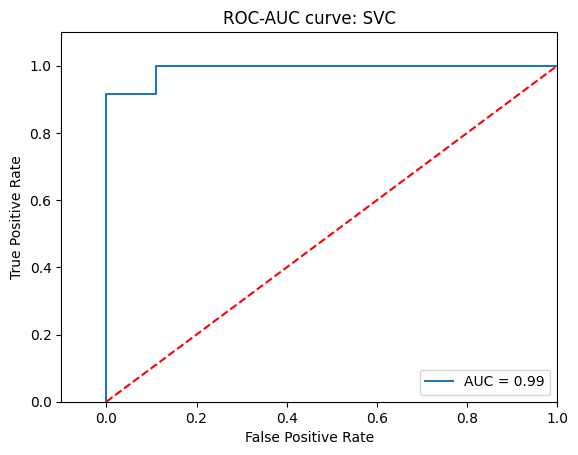

In [20]:
y_probas_svc = SVM_model.predict_proba(X_test)[:, 1]
fpr_svc, tpr_svc, thresholds_svc = metrics.roc_curve(y_test, y_probas_svc)
roc_auc_score_svc = metrics.roc_auc_score(y_test, y_probas_svc)

roc_auc_plot('ROC-AUC curve: SVC', fpr_svc, tpr_svc,
             'AUC = %0.2f', roc_auc_score_svc)

# Задание 5 (SGD)
Попробуйте применить классификатор SGDClassifier.


In [21]:
SGD_model = SGDClassifier(loss='log_loss').fit(X_train, y_train)
predicted_classes_sgd = log_reg.predict(X_test)

print(color.BOLD + 'SGD MODEL' + color.END)
print(metrics.classification_report(y_test, predicted_classes_sgd))

SGD MODEL
              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.96      0.96      0.96        24

    accuracy                           0.94        33
   macro avg       0.92      0.92      0.92        33
weighted avg       0.94      0.94      0.94        33



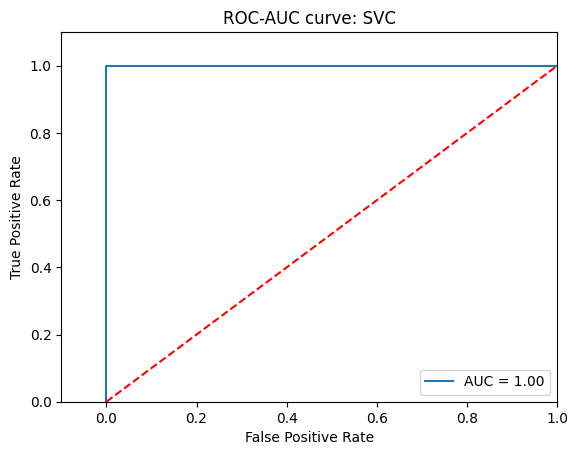

In [22]:
y_probas_sgd = SGD_model.predict_proba(X_test)[:, 1]
fpr_sgd, tpr_sgd, thresholds_sgd = metrics.roc_curve(y_test, y_probas_sgd)
roc_auc_score_sgd = metrics.roc_auc_score(y_test, y_probas_sgd)

roc_auc_plot('ROC-AUC curve: SVC', fpr_sgd, tpr_sgd,
             'AUC = %0.2f', roc_auc_score_sgd)